#### Import Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.layers import Resizing,Rescaling, InputLayer, Conv2D,MaxPool2D, Dropout,Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L1,L2

#### Constants

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

#### Loading Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "Main dataset",
  shuffle=True,
  labels='inferred',
  label_mode='categorical',
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  seed=99,
)

Found 3118 files belonging to 6 classes.


In [4]:
class_name=dataset.class_names# they will give you the name of classes 

In [5]:
class_name

['Aphids',
 'Army worm',
 'Bacterial Blight',
 'Healthy',
 'Powdery Mildew',
 'Target spot']

#### Visualization

(32, 256, 256, 3)
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


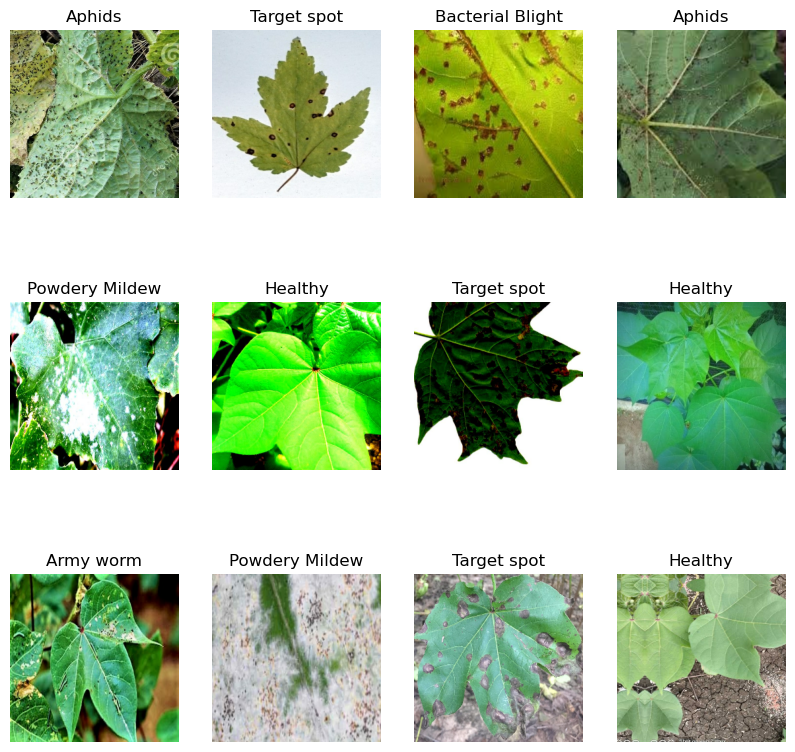

In [6]:
plt.figure(figsize=(10, 10))

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape) # batch_size, height, width, channels
    print(labels_batch.numpy())

    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # Get the index of the class name corresponding to the one-hot encoded label
        class_index = int(tf.argmax(labels_batch[i]))
        
        plt.title(class_name[class_index])
        plt.axis("off")

plt.show()


#### Data Splition

In [7]:
# Define split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [8]:
# Function to split dataset
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    
    # Calculate split sizes
    train_size = int(TRAIN_RATIO * DATASET_SIZE)
    val_size = int(VAL_RATIO * DATASET_SIZE)
    test_size = int(TEST_RATIO * DATASET_SIZE)

    # Shuffle and split the dataset
    dataset = dataset.shuffle(buffer_size=DATASET_SIZE, reshuffle_each_iteration=False)

    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [9]:
# Split dataset
train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [10]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [11]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [12]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IMAGE_SIZE,IMAGE_SIZE),
    Rescaling(1./255)
])

In [13]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [14]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

#### Lenet

In [15]:
dropout_rate = 0.5
regularization_rate = 0.08
model  = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate = dropout_rate),
    
    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(6, activation="softmax"),
])


C:\Users\Abubakar\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 98304)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       9,830,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,832,208 (37.51 MB)

 Trainable params: 9,831,976 (37.51 MB)

 Non-trainable params: 232 (928.00 B)

#### Metrices & Compilation

In [17]:
# metrics = [TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),
#            BinaryAccuracy(name='Accuracy'), Precision(name = 'precision'), Recall(name='recall'), AUC(name='auc')]

#metrics = [BinaryAccuracy(name='Accuracy')]

In [18]:
model.compile(
      optimizer="adam",
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
      #metrics = metrics
)

#### Training

In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=10
)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 54s 553ms/step - accuracy: 0.3355 - loss: 1.7320 - val_accuracy: 0.3111 - val_loss: 3.1545
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 549ms/step - accuracy: 0.5803 - loss: 1.2232 - val_accuracy: 0.7926 - val_loss: 0.7753
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 546ms/step - accuracy: 0.7278 - loss: 0.9559 - val_accuracy: 0.7222 - val_loss: 0.8838
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 53s 599ms/step - accuracy: 0.7887 - loss: 0.7562 - val_accuracy: 0.8741 - val_loss: 0.5581
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 563ms/step - accuracy: 0.8502 - loss: 0.5923 - val_accuracy: 0.9222 - val_loss: 0.3811
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 550ms/step - accuracy: 0.8838 - loss: 0.4842 - val_accuracy: 0.9556 - val_loss: 0.3332
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 546ms/step - accuracy: 0.9127 - loss: 0.3910 - val_accuracy: 0.9778 - val_loss: 0.2249
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 554ms/step - accuracy: 0.9225 - loss: 0.3302 - val_accu

#### Testing

In [20]:
scores=model.evaluate(test_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9943 - loss: 0.0915


#### Results

In [23]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

KeyError: 'Accuracy'

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#### Manual Testing

In [24]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)#create batch
    predictions=model.predict(img_array)
    predicted_class=class_name[np.argmax(batch_prediction[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

In [25]:
from ipywidgets import FileUpload
from IPython.display import display, Image as IPyImage
import numpy as np
import tensorflow as tf
from PIL import Image
import io


FileUpload(value={}, accept='image/*', description='Upload')

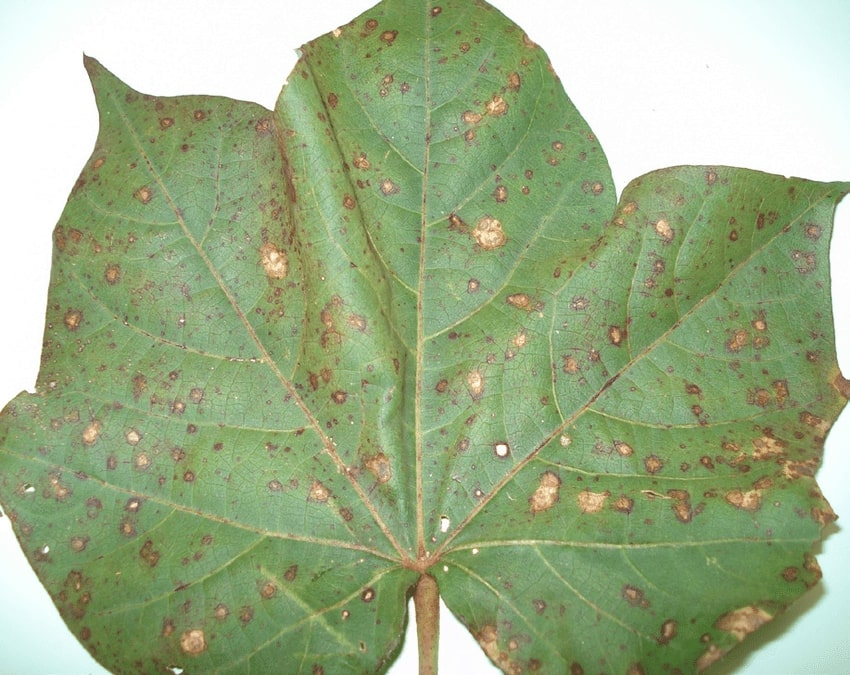

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted class: Target spot, Confidence: 98.8%


In [26]:
upload = FileUpload(accept='image/*', multiple=False)
display(upload)

In [27]:
# Replace `model` with your actual model variable
def predict_image_with_model(img_data, model):
    # Load and preprocess the image
    img = Image.open(io.BytesIO(img_data)).resize((256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    
    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = round(100 * np.max(predictions[0]), 2)
    
    # Translate prediction into your labels
    labels = {0: 'Aphids', 1: 'Army worm', 2: 'Bacterial Blight', 3:'Healthy', 4:'Powdery Mildew', 5:'Target spot'}
    predicted_label = labels[predicted_class]
    
    return predicted_label, confidence

In [28]:
def on_upload_change(change):
    if not upload.value:
        print("Please upload an image.")
        return
    
    # Get the uploaded file's content
    input_file = next(iter(upload.value.values()))
    content = input_file['content']
    
    # Display the uploaded image
    display(IPyImage(data=content))
    
    # Predict and display results
    predicted_class, confidence = predict_image_with_model(content, model)  # Ensure your model variable is correctly named
    print(f"Predicted class: {predicted_class}, Confidence: {confidence}%")

upload.observe(on_upload_change, names='_counter')


## Saving Model

In [21]:
# Save the model in H5 format
model.save('model.h5')

In [30]:
# Save the model in Keras format
model.save('model.keras')

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('model.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

# Save the TFLite model
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted and saved to converted_model.tflite")


INFO:tensorflow:Assets written to: C:\Users\Abubakar\AppData\Local\Temp\tmp3dyehrme\assets


INFO:tensorflow:Assets written to: C:\Users\Abubakar\AppData\Local\Temp\tmp3dyehrme\assets
